In [155]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import geoplot.crs as gcrs
import cartopy.crs as ccrs
import cartopy
import geoplot as gplt
import warnings

/Users/dario/Repos/ghg-emissions-usa/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [115]:
# Supressing FutureWarnings from seaborn
warnings.filterwarnings("ignore", category=FutureWarning)

In [78]:
sns.set_style("darkgrid")
sns.set_context("notebook")

## Loading dataset

In [3]:
emitters_full = pd.read_csv("data/epa_facilities_report_emitters.csv")

In [4]:
emitters_full.head()

,address1,address2,city,co2e_emission,county,facility_name,county_fips,gas_code,gas_name,facility_id,ghg_quantity,latitude,longitude,year,state,state_name,subpart_category,subpart_name,subpart_type,zip
0,5105 LAKE TERRELL ROAD,NaN,FERNDALE,138.250,WHATCOM COUNTY,PSE Ferndale Generating Station,53073.0,CH4,Methane,1000001,5.530,48.828707,-122.685533,2010,WA,WASHINGTON,Stationary Combustion,C,E,98248
1,5105 LAKE TERRELL ROAD,NaN,FERNDALE,164.794,WHATCOM COUNTY,PSE Ferndale Generating Station,53073.0,N2O,Nitrous Oxide,1000001,0.553,48.828707,-122.685533,2010,WA,WASHINGTON,Stationary Combustion,C,E,98248
2,5105 LAKE TERRELL ROAD,NaN,FERNDALE,292987.900,WHATCOM COUNTY,PSE Ferndale Generating Station,53073.0,CO2,Carbon Dioxide,1000001,292987.900,48.828707,-122.685533,2010,WA,WASHINGTON,Stationary Combustion,C,E,98248
3,5105 LAKE TERRELL ROAD,NaN,FERNDALE,17.000,WHATCOM COUNTY,PSE Ferndale Generating Station,53073.0,CH4,Methane,1000001,0.680,48.828707,-122.685533,2011,WA,WASHINGTON,Stationary Combustion,C,E,98248
4,5105 LAKE TERRELL ROAD,NaN,FERNDALE,20.264,WHATCOM COUNTY,PSE Ferndale Generating Station,53073.0,N2O,Nitrous Oxide,1000001,0.068,48.828707,-122.685533,2011,WA,WASHINGTON,Stationary Combustion,C,E,98248


## Cleaning dataset

We don't need all the data in the dataset, so we just select the columns of interest to us.

In [82]:
emitters = emitters_full[["co2e_emission", "facility_name", "gas_code", "gas_name",
                          "ghg_quantity", "latitude", "longitude", "year", "state",
                          "state_name", "subpart_category", "subpart_name"]]

emitters.head()

,co2e_emission,facility_name,gas_code,gas_name,ghg_quantity,latitude,longitude,year,state,state_name,subpart_category,subpart_name
0,138.250,PSE Ferndale Generating Station,CH4,Methane,5.530,48.828707,-122.685533,2010,WA,WASHINGTON,Stationary Combustion,C
1,164.794,PSE Ferndale Generating Station,N2O,Nitrous Oxide,0.553,48.828707,-122.685533,2010,WA,WASHINGTON,Stationary Combustion,C
2,292987.900,PSE Ferndale Generating Station,CO2,Carbon Dioxide,292987.900,48.828707,-122.685533,2010,WA,WASHINGTON,Stationary Combustion,C
3,17.000,PSE Ferndale Generating Station,CH4,Methane,0.680,48.828707,-122.685533,2011,WA,WASHINGTON,Stationary Combustion,C
4,20.264,PSE Ferndale Generating Station,N2O,Nitrous Oxide,0.068,48.828707,-122.685533,2011,WA,WASHINGTON,Stationary Combustion,C


## EDA

Let's see how the total emissions have developed over the years.


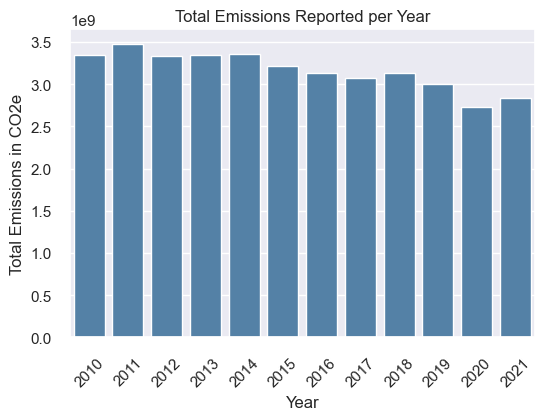

In [116]:
emissions_per_year = emitters.groupby("year")["co2e_emission"].sum().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=emissions_per_year, x="year", y="co2e_emission", color="steelblue")
plt.xlabel("Year")
plt.ylabel("Total Emissions in CO2e")
plt.title("Total Emissions Reported per Year")
plt.xticks(rotation=45)
plt.show()

It seems that there is a slight downward trend in the total emissions. However, we also need to look at how many facilities did report their emissions in those years.

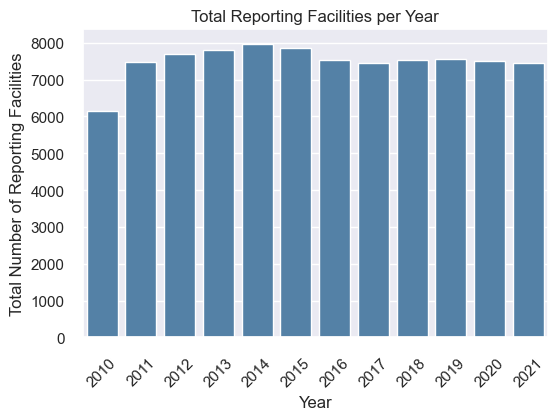

In [117]:
facilities_per_year = emitters.groupby("year")["facility_name"].nunique().reset_index()
facilities_per_year.columns = ["year", "distinct_facility_count"]


plt.figure(figsize=(6, 4))
sns.barplot(data=facilities_per_year, x="year", y="distinct_facility_count", color="steelblue")
plt.xlabel("Year")
plt.ylabel("Total Number of Reporting Facilities")
plt.title("Total Reporting Facilities per Year")
plt.xticks(rotation=45)
plt.show()

The number of reporting facilities has increased in the first couple of years and reached a peak in 2014. After that, it decreased again and has remained at around the same level from 2016 on.

With that in mind, we can have again a look at the total emissions graph above and see that from 2016 to 2021, the total emissions have decreased with 2020 and 2021 being clearly lower than the years before.

Now, let's have a look at which industries were the biggest greenhouse gas emitters in 2021.

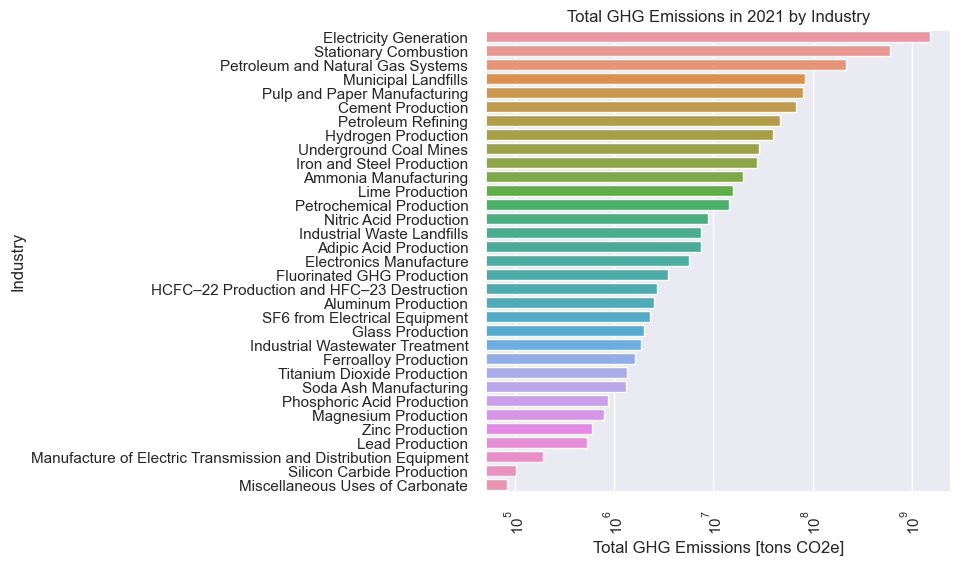

In [118]:
emitters_per_category = emitters[emitters["year"] == 2021].groupby("subpart_category")["co2e_emission"].sum().reset_index()
emitters_per_category.columns = ["subpart_category", "ghg_emissions_total"]

plt.figure(figsize=(6, 6))
sns.barplot(data=emitters_per_category,
            order=emitters_per_category.sort_values("ghg_emissions_total", ascending=False).subpart_category,
            x="ghg_emissions_total",
            y="subpart_category").set_xscale("log")
plt.xlabel("Total GHG Emissions [tons CO2e]")
plt.ylabel("Industry")
plt.title("Total GHG Emissions in 2021 by Industry")
plt.xticks(rotation=90)
plt.show()


We can also find out, how the 10 biggest emitting industries have developed over the years.

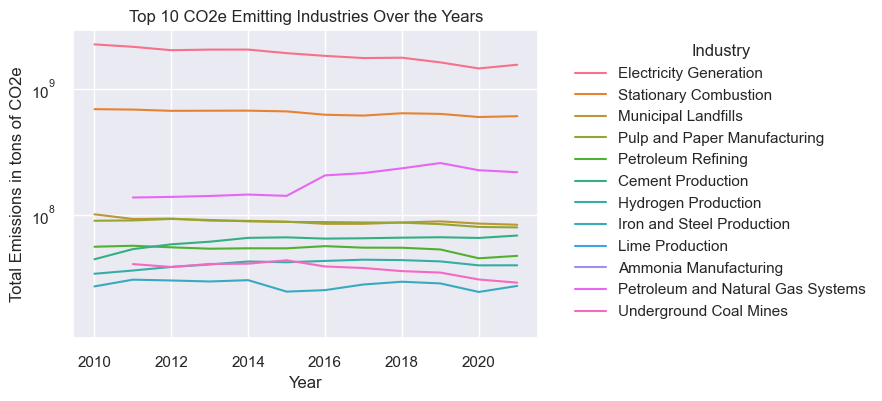

In [119]:
# Grouping and aggregating by year and industry
industry_emissions = emitters.groupby(["year", "subpart_category"])["co2e_emission"].sum().reset_index()

# Find the top 10 industries for each year
top_10_industries = industry_emissions.groupby("year").apply(lambda x: x.nlargest(10, "co2e_emission")).reset_index(drop=True)

# Create a line plot to visualize the emissions of the top 10 industries over the years
plt.figure(figsize=(6, 4))
sns.lineplot(data=top_10_industries, x="year", y="co2e_emission", hue="subpart_category").set_yscale("log")
plt.xlabel("Year")
plt.ylabel("Total Emissions in tons of CO2e")
plt.title("Top 10 CO2e Emitting Industries Over the Years")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

We see that most industries have generally lowered their overall emissions. However, the Petroleum and Natural Gas industry has apparently increased their emissions by quite a bit since the year 2015.

In [133]:
us_population = pd.read_excel("https://www2.census.gov/programs-surveys/popest/tables/2010-2019/state/totals/nst-est2019-01.xlsx",
                       skiprows=[0,1,2], skipfooter=5).dropna()                 # readin the dataset, skip irrelevant rows, drop empty rows
us_population.rename(columns={"Unnamed: 0":"area"}, inplace=True)           # rename the geographic area name column
us_population["area"] = us_population["area"].str.replace(".", "")      # remove extra . in the state names

us_state_population_2019 = us_population.drop(range(5))[["area", 2019]]      # drop the data of geographic areas larger than state and select the data of 2018
us_state_population_2019.columns = ["state", "population_2019"]
us_state_population_2019["state_name"] = us_state_population_2019.state.str.upper()     # turn the state names into upper case in order to join with the other dataframe
us_state_population_2019.head(10)
us_state_population_2019.count()

state              52
population_2019    52
state_name         52
dtype: int64

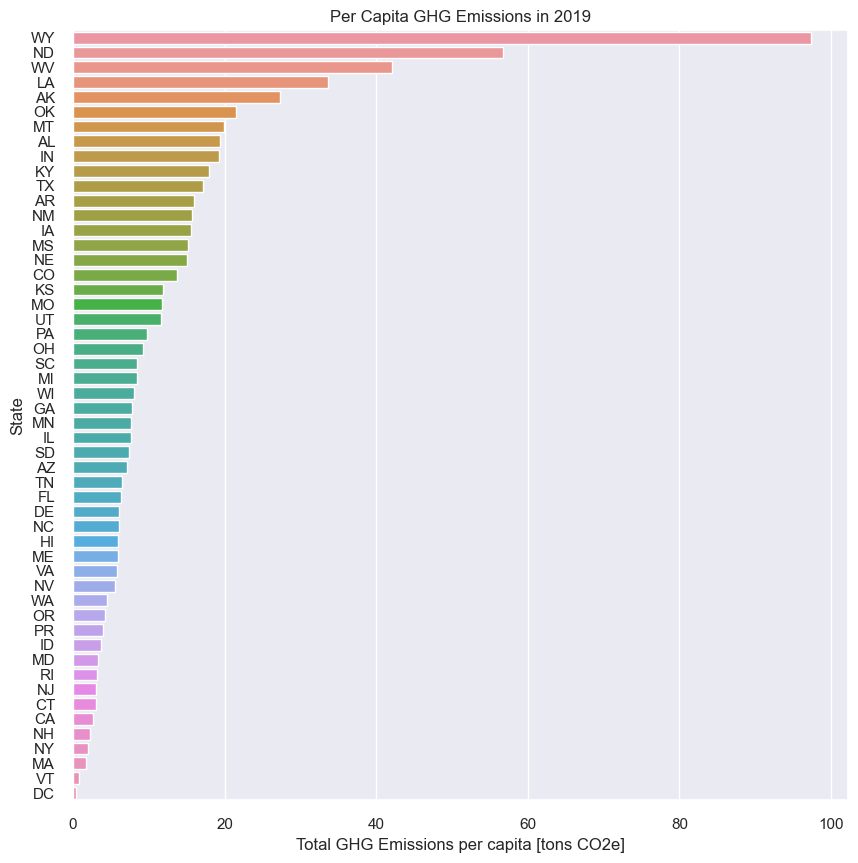

In [164]:
emitters_2019_states = emitters[emitters["year"] == 2019].groupby(["state_name", "state"]).co2e_emission.sum().reset_index()

emitters_2019_states = emitters_2019_states.merge(us_state_population_2019, how="left", on="state_name")
emitters_2019_states.columns = ["state_name_upper", "state_code", "co2e_emission", "state_name", "population_2019"]
emitters_2019_states.drop("state_name_upper", axis=1, inplace=True)

emitters_2019_states["co2e_emission_per_capita"] = emitters_2019_states.co2e_emission / emitters_2019_states.population_2019
emitters_2019_states = emitters_2019_states[~emitters_2019_states["state_code"].isin(["VI", "GU"])]

plt.figure(figsize=(10, 10))
sns.barplot(data=emitters_2019_states,
            order=emitters_2019_states.sort_values("co2e_emission_per_capita", ascending=False).state_code,
            x="co2e_emission_per_capita",
            y="state_code")
plt.xlabel("Total GHG Emissions per capita [tons CO2e]")
plt.ylabel("State")
plt.title("Per Capita GHG Emissions in 2019")
plt.show()

In [163]:
us_states_emissions_2019

,STUSPS,NAME,ALAND,AWATER,geometry,state_code,co2_emission,state_name,population_2019,co2_emission_per_capita
0,WV,West Virginia,62266456923,489045863,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...",WV,7.552076e+07,West Virginia,1792147.0,42.139825
1,FL,Florida,138962819934,45971472526,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",FL,1.349609e+08,Florida,21477737.0,6.283758
2,IL,Illinois,143778515726,6216539665,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...",IL,9.655594e+07,Illinois,12671821.0,7.619737
3,MN,Minnesota,206244837557,18937184315,"POLYGON ((-95.31989 48.99892, -95.31747 48.998...",MN,4.300530e+07,Minnesota,5639632.0,7.625551
4,MD,Maryland,25151771744,6979295311,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...",MD,1.982787e+07,Maryland,6045680.0,3.279676
5,RI,Rhode Island,2677763373,1323686975,"MULTIPOLYGON (((-71.67881 41.15891, -71.67626 ...",RI,3.361294e+06,Rhode Island,1059361.0,3.172945
6,ID,Idaho,214049908397,2391592787,"POLYGON ((-116.35844 49.00047, -116.34805 49.0...",ID,6.671847e+06,Idaho,1787065.0,3.733410
7,NH,New Hampshire,23190126218,1025960758,"POLYGON ((-70.83887 43.24449, -70.83886 43.244...",NH,3.011606e+06,New Hampshire,1359711.0,2.214887
8,NC,North Carolina,125935585728,13453835222,"POLYGON ((-77.89977 36.54460, -77.89942 36.544...",NC,6.374609e+07,North Carolina,10488084.0,6.077954
9,VT,Vermont,23872569964,1030754610,"POLYGON ((-72.04187 44.15665, -72.04180 44.156...",VT,4.678253e+05,Vermont,623989.0,0.749733


We can visualize this also on a map.

The shapefiles for the US states can be found on via the [Census Bureau](https://www.census.gov/cgi-bin/geo/shapefiles/index.php).

In [153]:
us_states_geometry = gpd.read_file("data/GIS/tl_2022_us_state.shp")

In [165]:
us_states_geometry = us_states_geometry[["STUSPS", "NAME", "ALAND", "AWATER", "geometry"]]      # select columns of interest
us_states_emissions_2019 = us_states_geometry.merge(emitters_2019_states, how="left", left_on="STUSPS", right_on="state_code")
us_states_emissions_2019.head()

,STUSPS,NAME,ALAND,AWATER,geometry,state_code,co2e_emission,state_name,population_2019,co2e_emission_per_capita
0,WV,West Virginia,62266456923,489045863,"POLYGON ((-77.75438 39.33346, -77.75422 39.333...",WV,7.552076e+07,West Virginia,1792147.0,42.139825
1,FL,Florida,138962819934,45971472526,"MULTIPOLYGON (((-83.10874 24.62949, -83.10711 ...",FL,1.349609e+08,Florida,21477737.0,6.283758
2,IL,Illinois,143778515726,6216539665,"POLYGON ((-87.89243 38.28285, -87.89334 38.282...",IL,9.655594e+07,Illinois,12671821.0,7.619737
3,MN,Minnesota,206244837557,18937184315,"POLYGON ((-95.31989 48.99892, -95.31747 48.998...",MN,4.300530e+07,Minnesota,5639632.0,7.625551
4,MD,Maryland,25151771744,6979295311,"POLYGON ((-75.75600 39.24607, -75.75579 39.243...",MD,1.982787e+07,Maryland,6045680.0,3.279676


In [156]:
# define Albers Equal Area projection for contiguous US in cartopy format
proj_aea_contig_us = ccrs.AlbersEqualArea(central_longitude=-96.0,
                                          central_latitude=37.5,
                                          standard_parallels=(29.5, 45.5))

# define Albers Equal Area projection for contiguous US in proj4 format
crs_aea_contig_us = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"

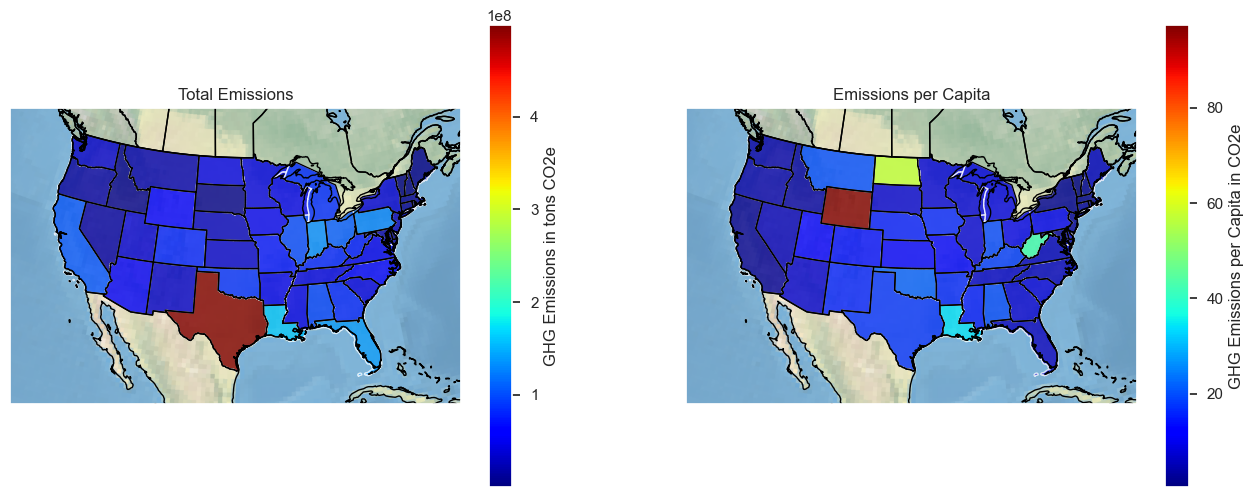

In [175]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2, subplot_kw={'projection': proj_aea_contig_us})

us_states_emissions_2019.to_crs(crs_aea_contig_us).plot(column='co2e_emission', ax=ax[0], cmap="jet", legend=True, alpha=0.8)
us_states_emissions_2019.to_crs(crs_aea_contig_us).plot(column='co2e_emission_per_capita', ax=ax[1], cmap="jet", legend=True, alpha=0.8)

for i in range(2):
    ax[i].set_extent([-123, -72, 20, 52])
    ax[i].stock_img()
    ax[i].coastlines()
    ax[i].add_feature(cartopy.feature.BORDERS)
    ax[i].add_feature(cartopy.feature.STATES)
    
ax[0].set_title("Total Emissions")
ax[1].set_title("Emissions per Capita")
fig.axes[2].set_ylabel("GHG Emissions in tons CO2e")
fig.axes[3].set_ylabel("GHG Emissions per Capita in CO2e");